# Higher-order Fluid Simulations on Periodic Boundaries with Φ<sub>Flow</sub>

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/prerendered/Higher_order_Kolmogorov.ipynb)

This notebook shows how to write a higher-order incompressible fluid simulation, simulating a Kolmogorov flow.
Higher-order finite difference schemes are available since Φ<sub>Flow</sub> 2.3.


## Higher-order Schemes in Φ<sub>Flow</sub>

The spatial order of all built-in finite-difference functions is specified using the `order` parameter.
By default, an explicit finite difference scheme is used.
For implicit schemes, pass `implicit=Solve(...)` where the `Solve` specifies the algorithm and tolerances.

The following options are implemented up to date:


<table>
<thead>
  <tr>
    <th>Differential operation<br></th>
    <th>Supported Schemes</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>field.spatial_gradient,<br>field.laplace,<br>field.divergence</td>
    <td>order=2,<br>order=4,<br>order=6, implicit=Solve(...)<br></td>
  </tr>
  <tr>
    <td>advect.finite_difference,<br>diffuse.finite_difference</td>
    <td>order=2,<br>order=4,<br>order=6, implicit=Solve(...)</td>
  </tr>
  <tr>
    <td>fluid.make_incompressible</td>
    <td>order=2,<br>order=4</td>
  </tr>
  <tr>
    <td>Field.at</td>
    <td>order=2,<br>order=6, implicit=Solve(...) (only available for sampling at midpoints)<br></td>
  </tr>
</tbody>
</table>

If [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow) 2.3 or newer is not already installed, uncomment the first line in the cell below.

In [23]:
# !pip install --upgrade phiflow

from phi.jax.flow import *
from tqdm.notebook import trange

math.set_global_precision(64)

## Pressure Forcing
The Kolmogorov flow uses a sinusoidal forcing along x which is added to the velocity at every time step.
We add a small perturbation in the form of `Noise` to violate symmetry and trigger a turbulent time development.

<Figure size 1200x500 with 4 Axes>

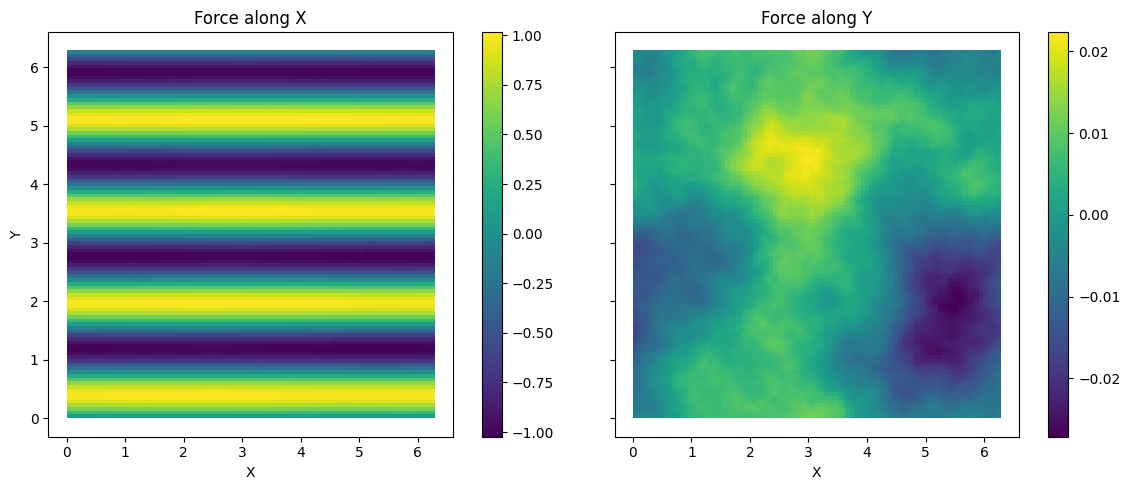

In [24]:
DOMAIN = dict(extrapolation=extrapolation.PERIODIC, bounds=Box(x=2*PI, y=2*PI), x=100, y=100)
FORCING = CenteredGrid(lambda x, y: vec(x=math.sin(4 * y), y=0), **DOMAIN) + CenteredGrid(Noise(), **DOMAIN) * 0.01
plot({'Force along X': FORCING['x'], 'Force along Y': FORCING['y']}, same_scale=False)

## Simulation
Next we define the momentum equation (PDE) for the incompressible flow.
We use 6th-order implicit advection and diffusion.
The pressure solve is integrated into Φ<sub>Flow</sub>'s 4th-order Runge-Kutta integrator `fluid.incompressible_rk4`. It uses a 4th-order direct scheme to avoid nested linear solves.
For all implicit operations, we use the conjugate gradient method `'CG'` since the periodic boundaries result in symmetric linear equation systems for which CG is fastest.

In [25]:
def momentum_equation(v, viscosity=0.001):
    advection = advect.finite_difference(v, v, order=6)
    diffusion = diffuse.finite_difference(v, viscosity, order=6)
    return advection + diffusion + FORCING

@jit_compile
def rk4_step(v, p, dt):
  return fluid.incompressible_rk4(momentum_equation, v, p, dt, pressure_order=4, pressure_solve=Solve('CG', 1e-5, 1e-5))

Let's run the simulation!

In [26]:
v0 = CenteredGrid(tensor([0, 0], channel(vector='x, y')), **DOMAIN)
p0 = CenteredGrid(0, **DOMAIN)
multi_step = lambda *x, **kwargs: iterate(rk4_step, 25, *x, **kwargs)
v_trj, p_trj = iterate(multi_step, batch(time=100), v0, p0, dt=0.005, range=trange)
vis.plot(field.curl(v_trj.with_extrapolation(0)), animate='time')

  0%|          | 0/100 [00:00<?, ?it/s]